# MNIST handwritten digits classification with decision trees 

In this notebook, we'll use [decision trees](http://scikit-learn.org/stable/modules/tree.html) and [ensembles of trees](http://scikit-learn.org/stable/modules/ensemble.html) to classify MNIST digits using scikit-learn and [XGBoost](https://xgboost.readthedocs.io/en/latest/).

First, the needed imports. 

In [8]:
%matplotlib inline

#from pml_utils import get_mnist, show_failures

import numpy as np
from sklearn import __version__
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
sns.set()

from distutils.version import LooseVersion as LV
assert(LV(__version__) >= LV("0.20")), "Version >= 0.20 of sklearn is required."
mnist = fetch_openml('mnist_784')

Then we load the MNIST data. First time we need to download the data, which can take a while.

In [18]:
#X_train, y_train, X_test, y_test = get_mnist('MNIST')
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
X_train, X_test,y_train, y_test = train_test_split( mnist.data, mnist.target, test_size=1/7.0, random_state=0)

print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 784)
y_train: (60000,)
X_test (10000, 784)
y_test (10000,)


## Decision tree

Decision tree is a model that predicts the value of a target variable by learning simple *if-then-else* decision rules inferred from the data features.

### Learning

Let's start by training a decision tree with default parameter values for classifying MNIST digits.

In [19]:
%%time

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)

CPU times: user 21.2 s, sys: 37.7 ms, total: 21.3 s
Wall time: 21.3 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

### Inference

Classifying a new sample with a decision tree is fast, as it consists of following a single path in the tree until a leaf node is found.

In [20]:
%%time

pred_dt = clf_dt.predict(X_test)
print('Predicted', len(pred_dt), 'digits with accuracy:', accuracy_score(y_test, pred_dt))

Predicted 10000 digits with accuracy: 0.8686
CPU times: user 37.2 ms, sys: 148 µs, total: 37.4 ms
Wall time: 36.1 ms


### Visualization

Decision trees are simple to understand and visualize.  Large trees can, however, be rather hard to inspect. 

The code below draws the trained decision tree classifier.  The resulting figure is huge, so it is better to save it as a separate file (`mydt.pdf`) and use a separate PDF viewer instead of drawing the figure into this notebook.  

To obtain a small tree for better suited for visualization, try adding the option `max_depth=3` to the above `DecisionTreeClassifier()`. 

In [22]:
export_graphviz(clf_dt, out_file="DecsionTree.dot")
with open("DecsionTree.dot") as f:
    dot_graph = f.read()
a=graphviz.Source(dot_graph)
print('Wrote PDF file:', a.render('DecsionTree', view=False))

Wrote PDF file: DecsionTree.pdf


## Random forest

Random forest is an ensemble (or a group; hence the name *forest*) of decision trees, obtained by introducing randomness into the tree generation. The prediction of the random forest is obtained by *averaging* the predictions of the individual trees.

Random forest is a solid workhorse that almost always produces serviceable results without much tuning.

### Learning

Random forest classifiers are quick to train, quite robust to hyperparameter values, and often work relatively well.

In [23]:
%%time

n_estimators = 10
clf_rf = RandomForestClassifier(n_estimators=n_estimators)
clf_rf.fit(X_train, y_train)

CPU times: user 5.19 s, sys: 64.4 ms, total: 5.25 s
Wall time: 5.27 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Inference

In [24]:
%%time

pred_rf = clf_rf.predict(X_test)
print('Predicted', len(pred_rf), 'digits with accuracy:', accuracy_score(y_test, pred_rf))

Predicted 10000 digits with accuracy: 0.9466
CPU times: user 55.3 ms, sys: 11.5 ms, total: 66.8 ms
Wall time: 65.6 ms


#### Failure analysis

The random forest classifier worked quite well, so let's take a closer look.

Here are the first 10 test digits the random forest model classified to a wrong class:

In [26]:
# Imported from pml_utils
def show_failures(predictions, y_test, X_test, trueclass=None,
                  predictedclass=None, maxtoshow=10):
    import matplotlib.pyplot as plt

    if len(predictions.shape) > 1:
        predictions = np.argmax(predictions, axis=1)
    errors = predictions != y_test
    print('Showing max', maxtoshow, 'first failures. The predicted class is '
          'shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(X_test.shape[0]):
        if ii >= maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and predictions[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(X_test[i, :].reshape(28, 28), cmap="gray")
            plt.title("%s (%s)" % (predictions[i], y_test[i]))
            ii = ii + 1

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


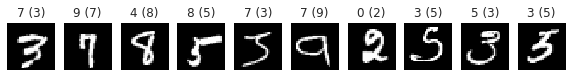

In [27]:
show_failures(pred_rf, y_test, X_test)

We can use `show_failures()` to inspect failures in more detail. For example:

* show failures in which the true class was "5":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


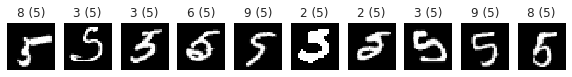

In [28]:
show_failures(pred_rf, y_test, X_test, trueclass='5')

* show failures in which the prediction was "0":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


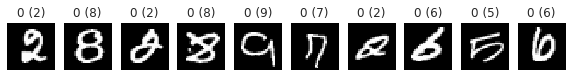

In [29]:
show_failures(pred_rf, y_test, X_test, predictedclass='0')

* show failures in which the true class was "0" and the prediction was "2":

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


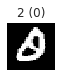

In [30]:
show_failures(pred_rf, y_test, X_test, trueclass='0', predictedclass='2')

#### Confusion matrix, accuracy, precision, and recall

We can also compute the confusion matrix to see which digits get mixed the most, and look at classification accuracies separately for each class:

In [31]:
labels=[str(i) for i in range(10)]
print('Confusion matrix (rows: true classes; columns: predicted classes):'); print()
cm=confusion_matrix(y_test, pred_rf, labels=labels)
print(cm); print()

print('Classification accuracy for each class:'); print()
for i,j in enumerate(cm.diagonal()/cm.sum(axis=1)): print("%d: %.4f" % (i,j))

Confusion matrix (rows: true classes; columns: predicted classes):

[[ 985    0    1    1    1    3    3    1    1    0]
 [   0 1121    5    2    3    2    0    4    3    1]
 [   4    3 1001    7    4    1    6    6    7    1]
 [   2    2   22  931    1   22    2   11   15    5]
 [   0    1    4    2  917    3    5    1    3   26]
 [   4    1    6   20    2  804   12    2    4    8]
 [   7    3    4    0    4   12  953    0    6    0]
 [   3    4   26    9    7    3    0  996    2   14]
 [   5   10   12   14    7   22    7    2  867   17]
 [   5    0    7   14   24    7    2   13    6  891]]

Classification accuracy for each class:

0: 0.9890
1: 0.9825
2: 0.9625
3: 0.9191
4: 0.9532
5: 0.9316
6: 0.9636
7: 0.9361
8: 0.9003
9: 0.9195


Precision and recall for each class:

In [32]:
print(classification_report(y_test, pred_rf, labels=labels))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       996
           1       0.98      0.98      0.98      1141
           2       0.92      0.96      0.94      1040
           3       0.93      0.92      0.92      1013
           4       0.95      0.95      0.95       962
           5       0.91      0.93      0.92       863
           6       0.96      0.96      0.96       989
           7       0.96      0.94      0.95      1064
           8       0.95      0.90      0.92       963
           9       0.93      0.92      0.92       969

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



## Gradient boosted trees (XGBoost)

Gradient boosted trees (or extreme gradient boosted trees) is another way of constructing ensembles of decision trees, using the *boosting* framework.  Let's use a popular separate package, [XGBoost](http://xgboost.readthedocs.io/en/latest/), to train gradient boosted trees to classify MNIST digits.  

XGBoost has been used to obtain record-breaking results on many machine learning competitions, but have quite a lot of hyperparameters that need to be carefully tuned to get the best performance.

### Learning

Training an XGBoost classifier takes a bit more time, so let's start by using only a subset of the training data. 

In [33]:
%%time

n_data = 10000
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train[:n_data,:], y_train[:n_data])

CPU times: user 3min 30s, sys: 139 ms, total: 3min 30s
Wall time: 3min 30s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Inference

At least with only a subset of training data and default hyperparameters values, XGBoost does not reach the performance of random forest.

In [34]:
%%time

pred_xgb = clf_xgb.predict(X_test)
print('Predicted', len(pred_xgb), 'digits with accuracy:', accuracy_score(y_test, pred_xgb))

Predicted 10000 digits with accuracy: 0.9194
CPU times: user 679 ms, sys: 32 ms, total: 711 ms
Wall time: 711 ms


You can also use `show_failures()` to inspect the failures, and calculate the confusion matrix and other metrics as was done with the random forest above.

## Model tuning

Study the documentation of the different decision tree models used in this notebook ([decision trees](http://scikit-learn.org/stable/modules/tree.html), [tree ensembles](http://scikit-learn.org/stable/modules/ensemble.html), [XGBoost](https://xgboost.readthedocs.io/en/latest/)), and experiment with different hyperparameter values.  

Report the highest classification accuracy you manage to obtain for each model type.  Also mark down the parameters you used, so others can try to reproduce your results. 